## Problem Overview
Hypertrophic cardiomyopathy (cardiomegaly) is a genetic condition where the heart muscle becomes abnormally thickened, making it harder for the heart to pump blood.
This project aims to develop a machine learning model that can accurately detect cardiomegaly from data about chest X-ray images from the `task_data.csv` file.

### Imports

In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import seaborn as sns

from sklearn.model_selection import (train_test_split, cross_val_score, StratifiedKFold,
cross_validate, cross_val_predict)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score)

### Loading the Data

In [182]:
df = pd.read_csv("task_data.csv", decimal=',')
print(f"Dataset loaded")
print(f"Shape: {df.shape}")

Dataset loaded
Shape: (37, 14)


### Data Overview

In [183]:
df.head()

,ID,Cardiomegaly,Heart width,Lung width,CTR - Cardiothoracic Ratio,xx,yy,xy,normalized_diff,Inscribed circle radius,Polygon Area Ratio,Heart perimeter,Heart area,Lung area
0,1,0,172,405,0.424691,1682.3608714590994,3153.671880299657,-638.5311091794423,-0.3042392565074078,68.81860,0.21344605475040257,679.487369,24898,75419
1,2,1,159,391,0.406650,1526.660959877028,5102.159053732461,-889.6784046829048,-0.5393868119084021,73.92564,0.20365244865718798,788.658942,29851,94494
2,5,0,208,400,0.520000,2465.9033921095847,5376.834706657514,-1755.3446985706441,-0.3711626319646625,69.33974,0.32078694801818824,862.322937,33653,66666
3,7,1,226,435,0.519540,2509.0635928775273,6129.821269595383,-1025.0798057957954,-0.4191232704635678,84.14868,0.3175446107949837,906.724959,42018,82596
4,8,1,211,420,0.502381,2368.7701350238644,5441.767074886623,-1493.0400615856156,-0.3934424556563858,73.78347,0.2635421805624075,864.239678,35346,85631


In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          37 non-null     int64  
 1   Cardiomegaly                37 non-null     int64  
 2   Heart width                 37 non-null     int64  
 3   Lung width                  37 non-null     int64  
 4   CTR - Cardiothoracic Ratio  37 non-null     float64
 5   xx                          37 non-null     object 
 6   yy                          37 non-null     object 
 7   xy                          37 non-null     object 
 8   normalized_diff             37 non-null     object 
 9   Inscribed circle radius     37 non-null     float64
 10  Polygon Area Ratio          37 non-null     object 
 11  Heart perimeter             37 non-null     float64
 12  Heart area                  37 non-null     int64  
 13  Lung area                   37 non-nu

Some columns with numerical values are stored as strings. We need to convert them to numeric types. There are no columns with categorical text features, so there is no need for encoding methods.

In [185]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = pd.to_numeric(df[col], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          37 non-null     int64  
 1   Cardiomegaly                37 non-null     int64  
 2   Heart width                 37 non-null     int64  
 3   Lung width                  37 non-null     int64  
 4   CTR - Cardiothoracic Ratio  37 non-null     float64
 5   xx                          37 non-null     float64
 6   yy                          37 non-null     float64
 7   xy                          37 non-null     float64
 8   normalized_diff             37 non-null     float64
 9   Inscribed circle radius     37 non-null     float64
 10  Polygon Area Ratio          37 non-null     float64
 11  Heart perimeter             37 non-null     float64
 12  Heart area                  37 non-null     int64  
 13  Lung area                   37 non-nu

In [186]:
# Checking for missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
ID                            0
Cardiomegaly                  0
Heart width                   0
Lung width                    0
CTR - Cardiothoracic Ratio    0
xx                            0
yy                            0
xy                            0
normalized_diff               0
Inscribed circle radius       0
Polygon Area Ratio            0
Heart perimeter               0
Heart area                    0
Lung area                     0
dtype: int64


No missing values were detected, so imputation is unnecessary

array([[<Axes: title={'center': 'Heart width'}>,
        <Axes: title={'center': 'Lung width'}>,
        <Axes: title={'center': 'CTR - Cardiothoracic Ratio'}>],
       [<Axes: title={'center': 'xx'}>, <Axes: title={'center': 'yy'}>,
        <Axes: title={'center': 'xy'}>],
       [<Axes: title={'center': 'normalized_diff'}>,
        <Axes: title={'center': 'Inscribed circle radius'}>,
        <Axes: title={'center': 'Polygon Area Ratio'}>],
       [<Axes: title={'center': 'Heart perimeter'}>,
        <Axes: title={'center': 'Heart area '}>,
        <Axes: title={'center': 'Lung area'}>]], dtype=object)

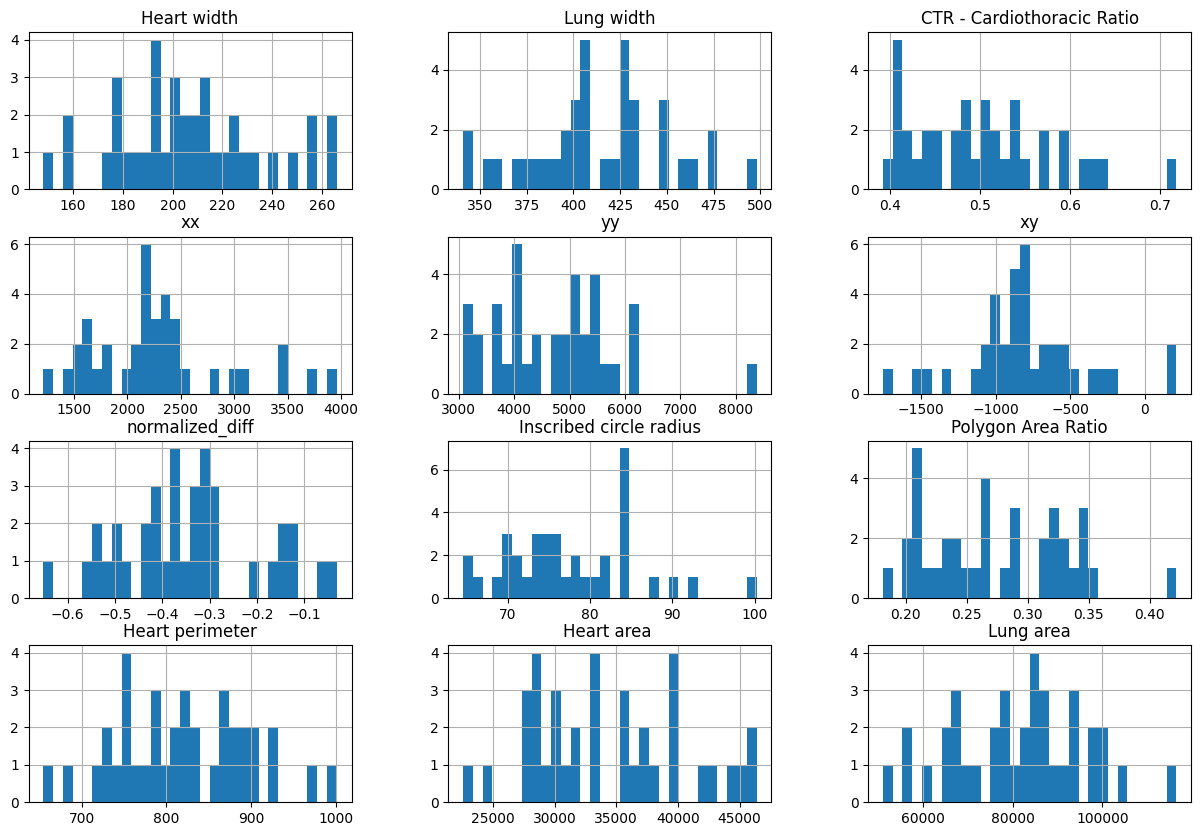

In [187]:
feature_columns = df.columns.drop(['ID', 'Cardiomegaly'])
df[feature_columns].hist(bins=30, figsize=(15, 10))

There are no features that are strongly heavy-tailed. Additionally, we don't have a large amount of data and some outliers may indicate the disease rather than noise.

In [188]:
corr = df.corr()
corr["Cardiomegaly"].sort_values(ascending=False)

Cardiomegaly                  1.000000
Inscribed circle radius       0.454456
Heart area                    0.447708
Heart perimeter               0.424253
xx                            0.383980
Heart width                   0.366739
CTR - Cardiothoracic Ratio    0.297782
yy                            0.250155
Polygon Area Ratio            0.210167
normalized_diff               0.170306
ID                            0.158145
Lung area                     0.137400
Lung width                    0.096037
xy                           -0.229837
Name: Cardiomegaly, dtype: float64

### Data Preparation
Features related to heart size have the biggest impact on the results. To improve the model performance, additional ratio-based features are created.

In [189]:
# Separate features and target
X = df.drop(['ID', 'Cardiomegaly'], axis=1)
y = df['Cardiomegaly']


In [190]:
# Create new features
X['Width Ratio'] = X['Heart width'] / X['Lung width']
X['Area Ratio'] = X['Heart area '] / X['Lung area']

print(f"\nFeature columns: {X.columns.tolist()}")


Feature columns: ['Heart width', 'Lung width', 'CTR - Cardiothoracic Ratio', 'xx', 'yy', 'xy', 'normalized_diff', 'Inscribed circle radius', 'Polygon Area Ratio', 'Heart perimeter', 'Heart area ', 'Lung area', 'Width Ratio', 'Area Ratio']


Due to the limited amount of data, both training and test sets are stratified to ensure a similar ratio of positive and negative cases

In [191]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

### Model Training
Given the complex and potentially nonlinear nature of the problem, three candidate algorithms are tested: Support Vector Classifier (SVC), Random Forest, and K-Nearest Neighbors (KNN). Optuna is used for hyperparameter optimization, with 5-fold stratified cross-validation. The F1_macro score is selected as the optimization metric due to its balanced treatment of both classes, which is crucial in case of class imbalance in the dataset (majority of positive cases).


In [192]:
optuna.logging.set_verbosity(optuna.logging.WARNING) #supress logs from optuna

# cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def svc_objective(trial):
    C = trial.suggest_float("C", 0.1, 20) #strength of the regularization 
    gamma = trial.suggest_float("gamma", 1e-4, 1e1) #kernel coefficient
    kernel = trial.suggest_categorical("kernel", ["rbf", "poly"]) # best kernels for non-linear  rekationships
    degree = trial.suggest_int("degree", 2, 7) if kernel == "poly" else 3 #degree of polynomial kernel function
    
    svc_pipe = Pipeline([
        ('scaler', StandardScaler()), #SVC is sensitive to feature scaling
        ('svc', SVC(C=C, gamma=gamma, kernel=kernel, degree=degree, random_state=42))
    ])

    scores = cross_val_score(svc_pipe, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)
    
    return scores.mean() #returns score, which optuna will try to optimize

print("Starting Optuna optimization for SVC")
svc_study = optuna.create_study(direction='maximize', study_name='svc_optimization')
svc_study.optimize(svc_objective, n_trials=100)

print(f"Best parameters: {svc_study.best_params}")
print(f"Best CV F1_macro: {svc_study.best_value:.4f}")

Starting Optuna optimization for SVC
Best parameters: {'C': 13.058419291970525, 'gamma': 5.105149071849595, 'kernel': 'poly', 'degree': 2}
Best CV F1_macro: 0.6272


In [193]:
def forest_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 350) # number of trees in the forest
    max_depth = trial.suggest_int("max_depth", 3, 18) # maximum depth of a tree; limited not to overfit the data
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10) # minimum number of samples required to split an internal node
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5) # minimum number of samples required to be at a leaf node
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None, 10]) # number of features to consider when looking for the best split
    
    forest_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        n_jobs= -1,
        random_state=42
    )

    scores = cross_val_score(forest_model, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)
    
    return scores.mean() # returns score, which optuna will try to optimize
    

print("Starting Optuna optimization for RandomForest")
forest_study = optuna.create_study(direction='maximize', study_name='forest_optimization')
forest_study.optimize(forest_objective, n_trials=100)

print(f"Best parameters: {forest_study.best_params}")
print(f"Best CV F1_macro: {forest_study.best_value:.4f}")

Starting Optuna optimization for RandomForest
Best parameters: {'n_estimators': 118, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}
Best CV F1_macro: 0.5906


In [194]:
def knn_objective(trial):
    n_neighbors = trial.suggest_int("n_neighbors", 3, 10) # number of neighbors to use
    weights = trial.suggest_categorical("weights", ["uniform", "distance"]) # weight function
    metric = trial.suggest_categorical("metric", ["euclidean", "manhattan", "minkowski", "cosine"]) # distance metric
    p = trial.suggest_int("p", 1, 4) if metric == "minkowski" else 2 # power parameter for minkowski metric
    knn_pipe = Pipeline([
        ('scaler', StandardScaler()), # KNN is sensitive to feature scaling
        ('knn', KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric, p=p))
    ])

    scores = cross_val_score(knn_pipe, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)
    
    return scores.mean() # returns score, which optuna will try to optimize

print("Starting Optuna optimization for KNN")
knn_study = optuna.create_study(direction='maximize', study_name='knn_optimization')
knn_study.optimize(knn_objective, n_trials=100)

print(f"Best parameters: {knn_study.best_params}")
print(f"Best CV F1_macro: {knn_study.best_value:.4f}")

Starting Optuna optimization for KNN
Best parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean'}
Best CV F1_macro: 0.7417


Based on cross-validation results, the K-Nearest Neighbors classifier achieves the highest F1-macro score and is selected for more complex evaluation.
### Final model evaluation
Training the best model (KNN) on the full training set and evaluating on the test set


In [195]:
final_model = Pipeline([
    ('scaler', StandardScaler()), #standardization is required
    ('knn', KNeighborsClassifier(**knn_study.best_params)) #dictionary unpacking
])
final_model.fit(X_train, y_train)
y_test_pred = final_model.predict(X_test)

Binary Metrics (positive class):
  Accuracy: 0.7500
  F1 Score: 0.8333
  Precision: 0.8333
  Recall: 0.8333

Macro Metrics (both classes equally weighted):
  F1_macro: 0.6667
  Precision_macro: 0.6667
  Recall_macro: 0.6667


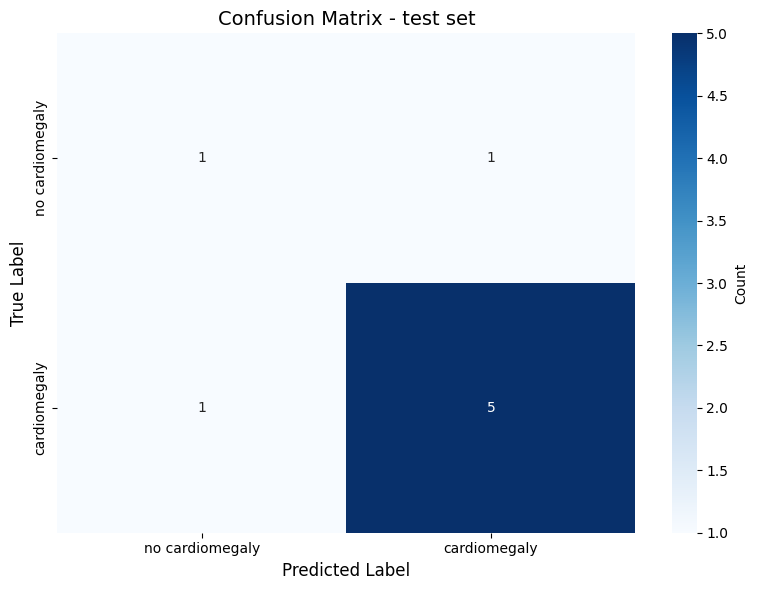

In [196]:
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')
test_precision = precision_score(y_test, y_test_pred)
test_precision_macro = precision_score(y_test, y_test_pred, average='macro')
test_recall = recall_score(y_test, y_test_pred)
test_recall_macro = recall_score(y_test, y_test_pred, average='macro')

print("Binary Metrics (positive class):")
print(f"  Accuracy: {test_accuracy:.4f}")
print(f"  F1 Score: {test_f1:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall: {test_recall:.4f}")
print("\nMacro Metrics (both classes equally weighted):")
print(f"  F1_macro: {test_f1_macro:.4f}")
print(f"  Precision_macro: {test_precision_macro:.4f}")
print(f"  Recall_macro: {test_recall_macro:.4f}")

#confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', 
            xticklabels=['no cardiomegaly', 'cardiomegaly'],
            yticklabels=['no cardiomegaly', 'cardiomegaly'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - test set', fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

Given the very small dataset, a simple hold-out evaluation may be unstable. To get a more reliable assessment, we perform evaluation with cross‑validated estimates on the full dataset using out‑of‑fold predictions.

In [197]:
scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'f1_macro': 'f1_macro',
    'precision': 'precision',
    'precision_macro': 'precision_macro',
    'recall': 'recall',
    'recall_macro': 'recall_macro'
}

cv_results = cross_validate( #dict of measured parameters instead of one value
    final_model, 
    X,  #whole dataset
    y,  #whole dataset
    cv=cv,
    scoring=scoring, #strategy to evaluate the performance
    n_jobs=-1
)

print("Binary Metrics (positive class):")
print(f"  Accuracy: {cv_results['test_accuracy'].mean():.4f}")
print(f"  F1 Score: {cv_results['test_f1'].mean():.4f}")
print(f"  Precision: {cv_results['test_precision'].mean():.4f}")
print(f"  Recall: {cv_results['test_recall'].mean():.4f}")
print("\nMacro Metrics (both classes equally weighted):")
print(f"  F1_macro: {cv_results['test_f1_macro'].mean():.4f}")
print(f"  Precision_macro: {cv_results['test_precision_macro'].mean():.4f}")
print(f"  Recall_macro: {cv_results['test_recall_macro'].mean():.4f}")

Binary Metrics (positive class):
  Accuracy: 0.8393
  F1 Score: 0.8998
  Precision: 0.8714
  Recall: 0.9333

Macro Metrics (both classes equally weighted):
  F1_macro: 0.7332
  Precision_macro: 0.7857
  Recall_macro: 0.7167


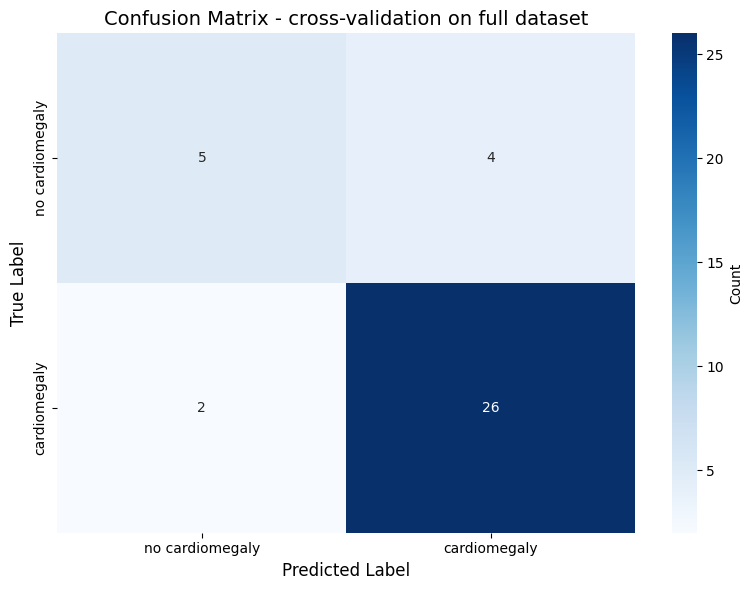

In [198]:
y_pred_cv = cross_val_predict(final_model, X, y, cv=cv)
cm_cv = confusion_matrix(y, y_pred_cv)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_cv, annot=True, cmap='Blues', 
            xticklabels=['no cardiomegaly', 'cardiomegaly'],
            yticklabels=['no cardiomegaly', 'cardiomegaly'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - cross-validation on full dataset', fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

### ROC and Precision-Recall Curves
Using more data for testing provides an opportunity to evaluate model performance across different decision thresholds by plotting ROC and Precision–Recall curves based on cross-validated predicted probabilities.

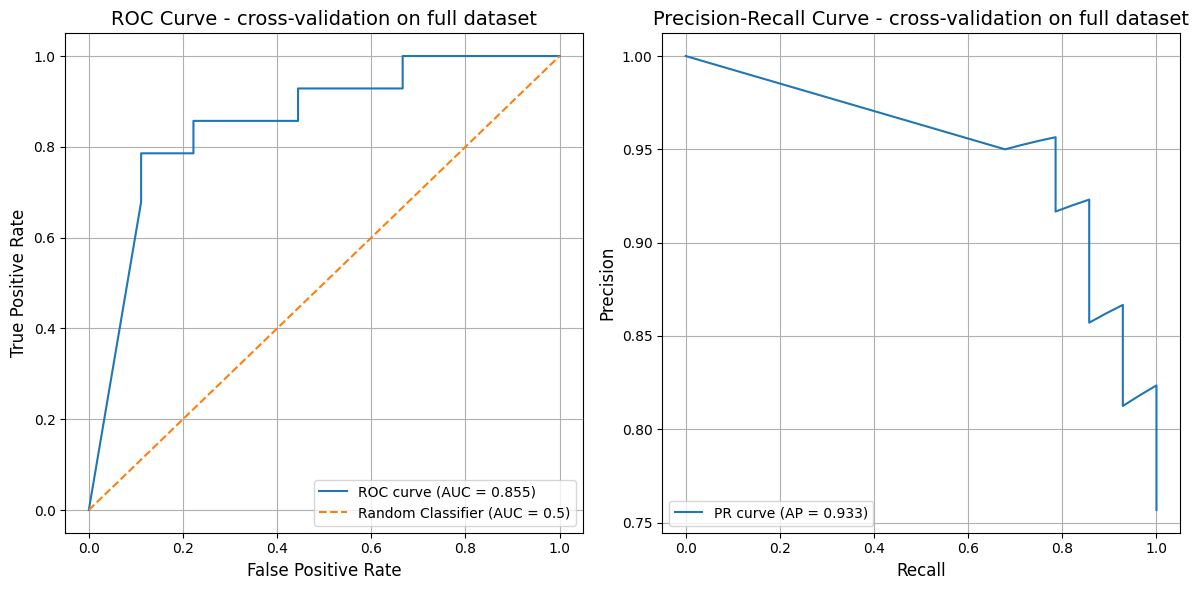

In [199]:
#compute probability of assigning to each class instead of assigning each sample to one class
y_proba_cv = cross_val_predict(final_model, X, y, cv=cv, method='predict_proba')[:, 1] #positive probabilities

#computing ROC curve and AUC
fpr, tpr, _= roc_curve(y, y_proba_cv)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(y, y_proba_cv)
avg_precision = average_precision_score(y, y_proba_cv)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6)) #rows, cols, figsize

#ROC curve
ax1.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
ax1.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier (AUC = 0.5)')
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('ROC Curve - cross-validation on full dataset', fontsize=14)
ax1.legend(loc="lower right")
ax1.grid()

#Precision-Recall curve
ax2.plot(recall, precision, label=f'PR curve (AP = {avg_precision:.3f})')
ax2.set_xlabel('Recall', fontsize=12)
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title('Precision-Recall Curve - cross-validation on full dataset', fontsize=14)
ax2.legend(loc="lower left")
ax2.grid()

plt.tight_layout()
plt.show()

### Evaluation Summary
Cross-validation demonstrates good model performance, consistent with validation on the test data. Due to more data with positive cases, the model achieves better performance in identifying disease cases, but also shows a tendency toward false positive predictions.

Based on the Precision–Recall curve (Average Precision = 0.933), the model maintains high precision even when configured for high recall, which is particularly important in medical diagnostics.

Based on the ROC curve (Area Under Curve = 0.855), the model demonstrates a good ability to distinguish between patients with and without cardiomegaly.
However, it is not sufficient as a independent diagnostic tool, as it can still produce a noticeable number of false positives and false negatives depending on the chosen decision threshold.

Given the limited amount of data, we should be cautious about overestimating the model’s applicability to real-world scenarios. However, the tuned KNN classifier demonstrates competitive and well-balanced performance, with strong recall and consistent cross-validated result.

### Final Model Training
After evaluation, we train the final model on the entire dataset to maximize its learning from all available data.

In [200]:
final_model.fit(X, y)
print("Final model trained")
print(f"Model: K-Nearest Neighbors")
print(f"Hyperparameters: {knn_study.best_params}")


Final model trained
Model: K-Nearest Neighbors
Hyperparameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean'}
